In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
import time

from math import *

from torchvision.transforms.functional import rotate

import pygame

DEVICE = "cuda"

pygame 2.1.2 (SDL 2.0.16, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [390]:
NUM_AGENTS = 8
NUM_STATES = 3
NUM_PERCEPTIONS = 3
NUM_ACTIONS = 512
NUM_THINGS = 3
RES = 512
MR = RES//2

yy,xx = np.meshgrid(np.arange(2*MR)-MR, np.arange(2*MR)-MR)
r2 = np.sqrt(xx**2 + yy**2)
r2 = t.FloatTensor(r2).unsqueeze(0).unsqueeze(1)        
xx = t.FloatTensor(xx).unsqueeze(0).unsqueeze(1)
yy = t.FloatTensor(yy).unsqueeze(0).unsqueeze(1)

def to_plt(img, detach=True): 
    return img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() if detach \
        else img.squeeze(0).permute(1, 2, 0).cpu().numpy()


class RadConv(nn.Module):
    def __init__(self, NI, NO, radius):
        super().__init__()
        self.conv = nn.Conv2d(NI, NO, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        
        avg_weight = t.zeros_like(self.conv.weight.data)
        
        for theta in np.arange(0,2*pi,pi/64.0):
            avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/pi)/128.0
        
        self.conv.weight.data = 4*avg_weight
    
    def forward(self, x):
        return self.conv(x)
        
class SimpleConvNet(nn.Module):
    def __init__(self, NI, NO = 1, radius=3):

        super().__init__()
        
        self.conv = RadConv(NI, NO, radius)
        self.relu = nn.ReLU()
        self.thresh = nn.Threshold(0.5, 0)
        self.sigmoid = nn.Sigmoid()
        self.glu = nn.GLU()
        

    def forward(self, x):
        x = self.conv(x)
        # x = self.relu(x)
        # x = self.sigmoid(x)
        # x = self.thresh(x)
        # x = t.clamp(x, 0, 1)
        return x        

In [391]:
# img = t.rand(1,3,RES,RES).cuda().squeeze(0).permute(1, 2, 0); img.shape
img = t.rand((1,3,RES,RES)).cuda(); img.shape

cnet = SimpleConvNet(3, 1, radius=3).cuda()

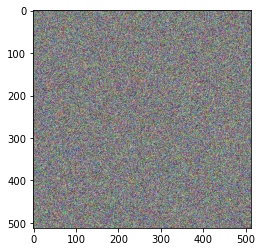

In [392]:
img = t.rand((1,3,RES,RES)).cuda()
# timg = F.threshold(img, 0.5, 0)
# timg = F.threshold(img, 0.5, 0)
timg = cnet(img)
plt.imshow(to_plt(img))

tensor([[[[-0.6733, -0.5480, -0.5512,  ..., -0.5567, -0.7404, -0.5619],
          [-0.4742, -0.1912, -0.4179,  ..., -0.5602, -0.4026, -0.5564],
          [-0.3473, -0.5055, -0.5181,  ..., -0.2700, -0.7038, -0.5540],
          ...,
          [-0.4299, -0.1757, -0.6055,  ..., -0.5744, -0.5269, -0.2928],
          [-0.5015, -0.6140, -0.7188,  ..., -0.7906, -0.7051, -0.3985],
          [-0.3838, -0.4516, -0.8040,  ..., -0.5812, -0.5200, -0.5609]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

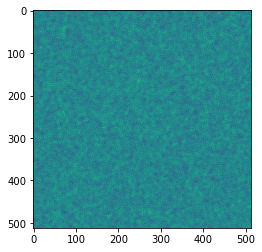

In [393]:
plt.imshow(to_plt(timg))
timg

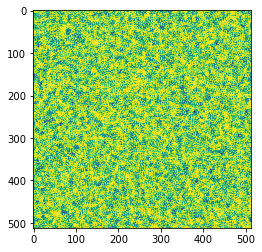

In [403]:
timg_norm = t.heaviside((timg - 0.5*t.min(timg)), t.cuda.FloatTensor([0]))
plt.imshow(to_plt(timg_norm))

In [406]:
timg_norm.max(), timg_norm.min()

(tensor(1., device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0', grad_fn=<MinBackward1>))

In [237]:
cimg = cnet(cimg)

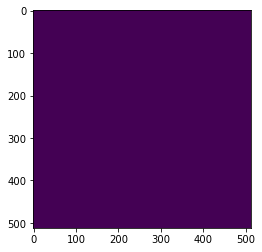

In [238]:
# plt.imshow(cimg.squeeze(0).permute(1, 2, 0)[:,:,0].detach().cpu().numpy())
plt.imshow(to_plt(cimg))

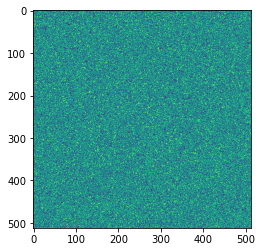

torch.Size([512, 512, 1])


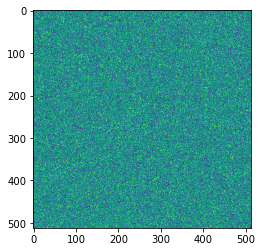

In [233]:
positions = t.rand((RES, RES, 1)).cuda(); print(positions.shape)
plt.imshow(positions.cpu().numpy())
# positions = t.rand((1, RES, RES, 3)).cuda(); print(positions.shape); print(positions.squeeze(0).shape)
# plt.imshow(positions.squeeze(0)[:,:,0].cpu().numpy())


In [113]:
positions = t.rand(NUM_AGENTS, 2).cuda(); print(positions.shape)
directions = t.tensor([theta for theta in np.arange(0,2*np.pi,np.pi/256.0)]).cuda().view(NUM_ACTIONS, 1); print(directions.shape)
num_directions = directions.shape[0]; print(num_directions)
speeds = t.tensor([speed for speed in t.rand(num_directions)]).cuda().view(NUM_ACTIONS, 1); print(speeds.shape)
actions = t.cat([speeds, directions], 1); print(actions.shape)

torch.Size([8, 2])
torch.Size([512, 1])
512
torch.Size([512, 1])
torch.Size([512, 2])


In [4]:
radius = 5

class Agent(nn.Module):
    
    def __init__(self, position = t.rand(RES, RES), action = t.rand(size = (1, NUM_ACTIONS)), state = t.rand(1, NUM_STATES), perception = t.rand(1, NUM_PERCEPTIONS)):
        super().__init__()
        
        self.position = position; print(self.position.shape)
        print(position)
        self.action = action; print(self.action.shape)
        self.state = state; print(self.state.shape)
        self.perception = perception; print(self.perception.shape)

        # self.action = action.view(-1, 1); print(self.action.shape)
        # self.state = state.view(-1, 1); print(self.state.shape)
        # self.perception = perception.view(-1, 1); print(self.perception.shape)
        self.config = t.cat([self.perception.view(-1, NUM_PERCEPTIONS), self.state.view(-1, NUM_STATES), self.action.view(-1, NUM_ACTIONS)], dim = 1); print(self.config.shape)
        
        self.percept = RadConv(NI = NUM_PERCEPTIONS+NUM_STATES, NO = NUM_PERCEPTIONS+NUM_STATES, radius = radius) #things in the environment; other agents states, their perception etc; NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        # self.conv = nn.Conv2d(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_PERCEPTIONS*NUM_STATES, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        self.fc1 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_PERCEPTIONS+NUM_STATES)
        self.fc2 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_PERCEPTIONS)
        self.fc3 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_STATES)
        self.fc4 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_ACTIONS)

    def forward(self, x):
        print(self.state)
        perception, states = F.relu(self.percept(x)) #should be NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS -> NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        # perception, states = F.relu(self.conv(x))
        print(perception)
        print(states)
        self.perception = F.relu(self.fc1(t.tensor(t.cat([perception, states], dim=0)).view(-1, NUM_PERCEPTIONS+NUM_STATES))); print(self.perception)
        self.perception = F.softmax(self.fc2(self.perception))
        self.state = F.softmax(self.fc3(self.perception).view(-1, NUM_STATES))
        self.action = F.softmax(self.fc4(self.perception).view(-1, NUM_ACTIONS))
        self.config = t.tensor(t.cat([self.perception, self.state, self.action], dim=1))
        return self.config

In [5]:
Agent().config


torch.Size([512, 512])
tensor([[0.6436, 0.1657, 0.0183,  ..., 0.0146, 0.7554, 0.4294],
        [0.8607, 0.8119, 0.4676,  ..., 0.3828, 0.7251, 0.3021],
        [0.7583, 0.6176, 0.8215,  ..., 0.7909, 0.0720, 0.1656],
        ...,
        [0.6884, 0.4218, 0.9399,  ..., 0.4075, 0.6524, 0.0902],
        [0.1690, 0.3186, 0.8907,  ..., 0.1667, 0.2425, 0.9091],
        [0.7027, 0.3399, 0.7627,  ..., 0.4011, 0.8463, 0.0295]])
torch.Size([1, 512])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 518])


TypeError: cos(): argument 'input' (position 1) must be Tensor, not numpy.float64

In [15]:
preys_[0].state

NameError: name 'preys_' is not defined

In [20]:
agents = dict(preys=t.tensor([prey.state for prey in preys_]).view(-1, 1), predators=t.tensor([predator.state for predator in predators]).view(-1, 1))

AttributeError: 'Prey' object has no attribute 'state'

In [130]:
class Environment(nn.Module):
    def __init__(self, spatial_contents, env_state, preys, predators):
        super(Environment, self).__init__()
        self.spatial_contents = spatial_contents
        self.config = env_state
        self.predators = predators
        self.preys = preys
        self.fc1 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_ACTIONS) # env_variables + (positions + action + perceptions) of all agents -> some number
        self.fc2 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_PERCEPTIONS)
        self.fc3 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_STATES)
        # self.fc3 = nn.Linear(128, contents)
    
    def _state(self):
        self.config = t.cat(t.tensor([self.predators, self.preys]))
        return self.config
    
    def __get__(self, x=None):
        x = self._state()
        return self.forward(x)

    def forward(self, x):
        
        # x = t.cat(
        #     [t.tensor(list(self.env_state.values)).view(-1, 1), 
        #     t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in self.predators])).view(-1, 1), 
        #     t.flatten(t.tensor([[prey.state, prey.perceptions, prey.actions] for prey in self.preys]))]).cuda()
        
        x = self.config.view(-1, 1)         
        actions = F.softmax(F.relu(self.fc1(x)).view(NUM_AGENTS, NUM_ACTIONS))
        perceptions = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_PERCEPTIONS))
        states = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_STATES))
        return t.cat([actions, perceptions, states]).cuda()

In [142]:
env = Environment(t.tensor([]), t.cat(t.tensor([predators, preys]) ), preys, predators)

Conf = env(env.config)

RuntimeError: Could not infer dtype of Predator

In [118]:
[p.forward() for p in env.predators]

TypeError: Agent.forward() missing 1 required positional argument: 'x'

In [111]:
class Environment(nn.Module):
    def __init__(self, spatial_contents, env_state, agents):
        super(Environment, self).__init__()
        self.spatial_contents = spatial_contents
        self.state = env_state
        self.predators = agents["predators"]
        self.preys = agents["preys"]
        self.fc1 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_ACTIONS) # env_variables + (positions + action + perceptions) of all agents -> some number
        self.fc2 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_PERCEPTIONS)
        self.fc3 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_STATES)
        # self.fc3 = nn.Linear(128, contents)

    def forward(self, x):
        
        x = t.cat(
            [t.tensor(list(self.env_state.values)).view(-1, 1), 
            t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in self.predators])).view(-1, 1), 
            t.flatten(t.tensor([[prey.state, prey.perceptions, prey.actions] for prey in self.preys]))]).cuda()
            
        actions = F.softmax(F.relu(self.fc1(x)).view(NUM_AGENTS, NUM_ACTIONS))
        perceptions = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_ACTIONS))
        states = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_ACTIONS))
        return t.cat([actions, perceptions, states])

In [46]:
t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in predators])).view(-1, 1)

NameError: name 'predators' is not defined

In [ ]:
pygame.init()
screen = pygame.display.set_mode((MULT*RES,MULT*RES), 0, 24)
